## Preprocessing and Training Data

In preceding notebooks, performed preliminary assessments of data quality and refined the question to be answered. We found a small number of data values that gave clear choices about whether to replace values or drop a whole row. We determined that predicting the Fare was our primary aim. We threw away records with missing price data, but not before making the most of the other available data to look for any patterns between the airlines. We didn't see any and decided to treat all airlines equally; the year label didn't seem to be particularly useful, as well as numerical features.

In this notebook we'll start to build machine learning models. Before even starting with learning a machine learning model, however, we will start by considering how useful the median value is as a predictor. We never want to go to stakeholders with a machine learning model only to have the CEO point out that it performs worse than just guessing the median! The first model is a baseline performance comparitor for any subsequent model. We then build up the process of efficiently and robustly creating and assessing models against it. 

## Import and Load Data

In [4]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

import datetime

In [5]:
af_data = pd.read_csv('../data/airfare_data_step3_features.csv')

In [6]:
af_data.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare,Month,Day,Part of the month,Route,Booking_Category
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335,1,16,Middle,Delhi to Mumbai,Last-minute
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899,1,16,Middle,Delhi to Mumbai,Last-minute
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801,1,16,Middle,Delhi to Mumbai,Last-minute
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794,1,16,Middle,Delhi to Mumbai,Last-minute
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955,1,16,Middle,Delhi to Mumbai,Last-minute


In [7]:
af_data.shape

(445366, 18)

In [8]:
af_data.dtypes

Date_of_journey       object
Journey_day           object
Airline               object
Flight_code           object
Class                 object
Source                object
Departure             object
Total_stops           object
Arrival               object
Destination           object
Duration_in_hours    float64
Days_left              int64
Fare                   int64
Month                  int64
Day                    int64
Part of the month     object
Route                 object
Booking_Category      object
dtype: object

## Encoding

In [10]:
cat_data = af_data[['Journey_day','Airline','Class','Total_stops','Arrival','Departure','Part of the month','Route','Booking_Category']]

In [11]:
encoded = pd.get_dummies(cat_data, drop_first=True)

print(encoded.shape)

(445366, 68)


## Train/test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(encoded, af_data['Fare'], test_size=0.3, random_state = 47)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(311756, 68) (133610, 68) (311756,) (133610,)


Since all our X values were converted to binary values via dummy encoding then no scaling is needed.

In [14]:
train_median = y_train.median()
train_median

13379.0

In [15]:
dumb_reg = DummyRegressor(strategy='median')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[13379.]])

We use the median here instead of the mean because our dataset has many outliers due to the natural price variation in airfare. We can also see that the medians are the same here. 

In [17]:
#Calculate the R^2
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

In [18]:
y_tr_pred_ = train_median * np.ones(len(y_train))
y_tr_pred_[:5]

array([13379., 13379., 13379., 13379., 13379.])

In [19]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([13379., 13379., 13379., 13379., 13379.])

You can see that `DummyRegressor` produces exactly the same results and saves you having to mess about broadcasting the mean to an array of the appropriate length. 

In [21]:
r_squared(y_train, y_tr_pred)

-0.219546611318151

Out target variable has extreme outliers or an unusual distribution, the dummy regressor predictions might be far from most of the true values.

In [23]:
y_te_pred = train_median * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-0.21724301667885637

In [24]:
#Calculate the MAE
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [25]:
mae(y_train, y_tr_pred)

14288.593877904515

In [26]:
mae(y_test, y_te_pred)

14272.575892523015

Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around 14273 rupies if you guessed ticket price based on an average of known values.

In [28]:
#Calculate the MSE which tells us how close a regression line is to a set of data points
# a good model will have an MSE closer to 0, indicating a better goodness of fit to the data
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [29]:
mse(y_train, y_tr_pred)

506460342.9632052

In [30]:
mse(y_test, y_te_pred)

508088826.89703614

Woah that does not look right. The MSE is very high this is probably due to the outliers in the data, we will have to rely on more robust metrics for this model such as MAE.

In [32]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([22504.67380264, 22540.82578117])

In [33]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(-0.219546611318151, -0.21724301667885637)

In [34]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(14288.593877904515, 14272.575892523015)

In [35]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(506460342.9632052, 508088826.89703614)

## Initial modeling

In [37]:
lm = LinearRegression().fit(X_train, y_train)

In [38]:
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [39]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.559501404915121, 0.5593245551142745)

Recall that we estimated ticket price by simply using a known median. As expected, this produced a negative $R^2$ value for both the training and test set, because $R^2$ tells us how much of the variance you're explaining beyond that of using just the median, and you were using just the median. Here we see that our simple linear regression model explains about 56% of the variance on the train set and about 56% on the test set. Clearly we are onto something. This suggests our model is moderately effective and since the train and test set $R^2$ value are close then the model generalizes well.  

In [40]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(9424.443955553827, 9430.621712607834)

Using this model, then, on average you'd expect to estimate airfare within 9430 rupies or so of the real price. This is not the best prediction, maybe with more hyperparameter tuning or even a different model we can get a better prediction.

In [41]:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(182932794.42625386, 183942127.22223377)

These results don't seem very different to when we used the median. Perhaps it doesn't make much difference here. Maybe other feature transformations, such as taking the log, would help. 

## Pipelines

Now we want to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. `make_pipeline` automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. We know the name of the step will be 'selectkbest' and we know the parameter is 'k'.

In [42]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    LinearRegression()
)

In [43]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [44]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [45]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.559501404915121, 0.5593245551142743)

Not suprised that with no hyperparameter tuning there is no change in the performance of the model.

In [46]:
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    SelectKBest(f_regression, k = 15),
    LinearRegression()
)

In [47]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x7f92bc8cd0d0>)),
                ('linearregression', LinearRegression())])

In [50]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [51]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.5382422660043918, 0.5387282136495707)

In [52]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9549.079914177217, 9562.399846090026)

In [53]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [54]:
cv_scores = cv_results['test_score']
cv_scores

array([0.53741156, 0.54138452, 0.53808662, 0.53400028, 0.5402052 ])

In [55]:
np.mean(cv_scores), np.std(cv_scores)

(0.5382176355326644, 0.0025468650386534105)

In [56]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.53, 0.54])

We can also see that with K=15 the performance decreases. Let's figure out the best K value for optimal performance of the model.

In [57]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [58]:
lr_grid_cv = GridSearchCV(pipe15, param_grid=grid_params, cv=5, n_jobs=-1)

In [59]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('selectkbest',
                                        SelectKBest(k=15,
                                                    score_func=<function f_regression at 0x7f92bc8cd0d0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [60]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [61]:
lr_grid_cv.best_params_

{'selectkbest__k': 68}

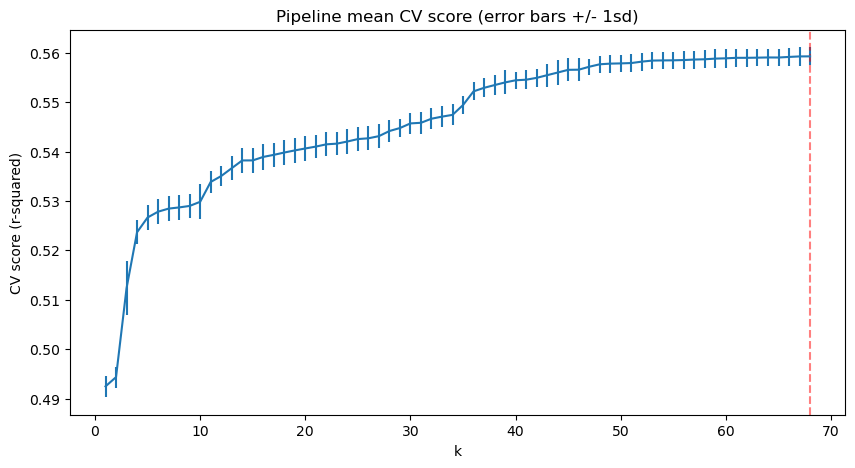

In [62]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k for this linear regression model is 68. 

In [64]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Class_Premium                 28153.877977
Route_Kolkata to Delhi         7305.003143
Route_Delhi to Kolkata         7278.804172
Route_Kolkata to Mumbai        6365.114079
Route_Kolkata to Bangalore     5392.856188
                                  ...     
Airline_Indigo                -5334.922191
Airline_SpiceJet              -5461.462795
Booking_Category_Planned      -6152.606432
Airline_AirAsia               -6870.251816
Total_stops_non-stop          -9009.499446
Length: 68, dtype: float64

These results suggest that the premium class is the biggest positive feature, meaning it increases the price. This makes intuitive sense and is consistent with what we saw during the EDA work. Also, you see the Routes from Kolkata have a strong positive influence as well. Non-stop flights are negatively associated with airfare. This seems accurate. People will pay less for non-stop flights; people want the least amount of travel time possible to get to their destination faster.

## Gradient Boosting Regressor

Let's test our data on a different type of model, Gradient Boosting Regressor. It may be more optimal for our dataset because it is better at handling complex datasets such as ours and it is robust to outliers which our dataset is abundant in.

In [132]:
GB_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingRegressor(random_state=47)
)

In [136]:
rf_default_cv_results = cross_validate(GB_pipe, X_train, y_train, cv=15)

In [142]:
gb_cv_scores = rf_default_cv_results['test_score']
gb_cv_scores

array([0.59929708, 0.60344487, 0.60345903, 0.61005745, 0.60698114,
       0.60624827, 0.60296461, 0.60699831, 0.60323244, 0.60404205,
       0.59738051, 0.60075672, 0.60511925, 0.60133235, 0.60667337])

In [144]:
np.mean(gb_cv_scores), np.std(gb_cv_scores)

(0.6038658300234008, 0.003199877065001775)

Gradient Boosting has a number of hyperparameters that can be explored, however here we'll limit ourselves to exploring some different values for the number of trees.

In [146]:
params = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'gradientboostingregressor__max_depth': [3, 5, 7],
    'gradientboostingregressor__min_samples_split': [2, 5, 10]
}

In [148]:
random_search = RandomizedSearchCV(estimator=GB_pipe, param_distributions=params,
                                   n_iter=25, cv=3, n_jobs=-1, verbose=2, random_state=42)

In [150]:
random_search.fit(X_train, y_train)
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200; total time= 5.7min
[CV] END gradientboostingregressor__learning_rate=0.1, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=50; total time=  52.4s
[CV] END gradientboostingregressor__learning_rate=0.3, gradientboostingregressor__max_depth=5, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200; total time= 5.3min
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_estimators=100; total time= 3.9min
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=3, gradientboosting

In [170]:
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)

Best parameters found by RandomizedSearchCV: {'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__learning_rate': 0.2}


In [172]:
gb_best_cv_results = cross_validate(random_search.best_estimator_, X_train, y_train, cv=3)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200; total time= 5.7min
[CV] END gradientboostingregressor__learning_rate=0.1, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=50; total time=  52.2s
[CV] END gradientboostingregressor__learning_rate=0.3, gradientboostingregressor__max_depth=5, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200; total time= 5.3min
[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=3, gradientboostingregressor__min_samples_split=2, gradientboostingregressor__n_estimators=50; total time=  57.0s
[CV] END gradientboostingregressor__learning_rate=0.2, gradientboostingregressor__max_depth=7, gradientboostingregressor__min_samples_split=10, gradientboostingregressor__n_

array([0.65557833, 0.65894419, 0.65344525])

In [176]:
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.655989254899917, 0.002263660941740931)

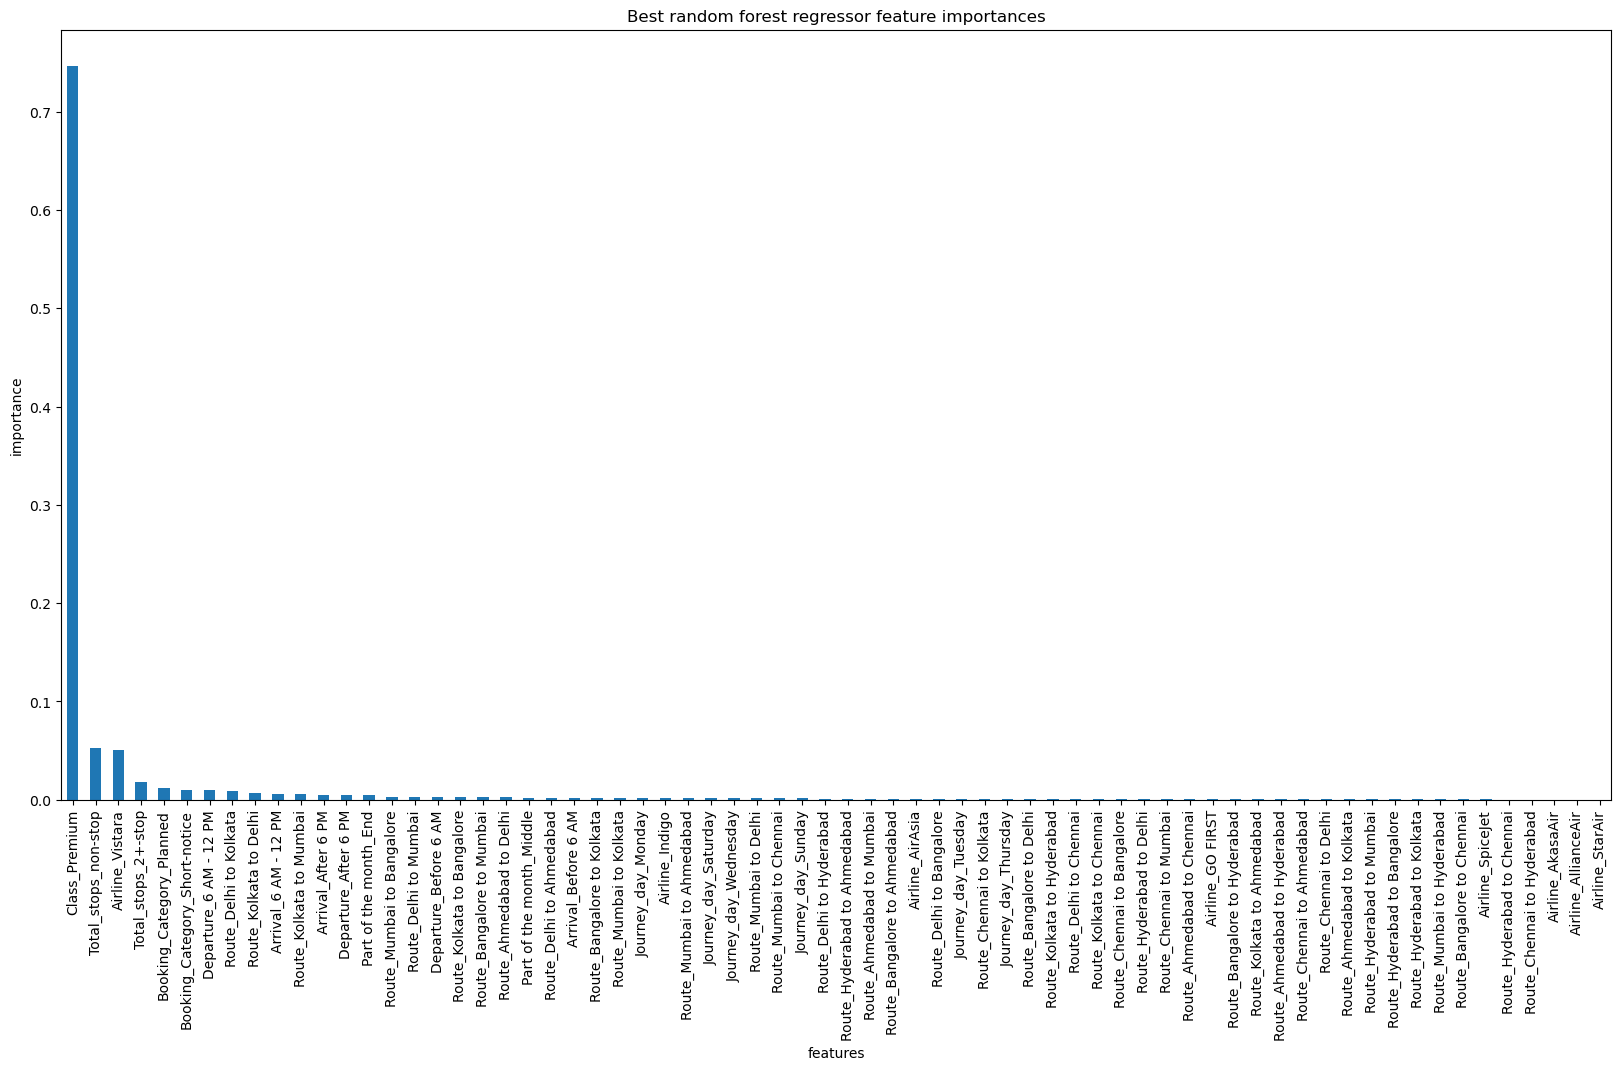

In [187]:
plt.subplots(figsize=(20, 10))
imps = random_search.best_estimator_.named_steps['gradientboostingregressor'].feature_importances_

gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.plot(kind='bar')
plt.xlabel('features')
#plt.xticks(rotation=45)
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

Encouragingly, the dominant features are similar to the linear model:
* Class_Premium
* Total_stops_non-stop
* Airline_Vistara
* Total_stops_2+-stop

## Final Model Selection

Time to select the final model to use for further business modeling! It would be good to revisit the above model selection; there is undoubtedly more that could be done to explore possible hyperparameters.
It would also be worthwhile to investigate removing the least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed.
Building a simpler model with fewer features can also have the advantage of being easier to sell (and/or explain) to stakeholders.
Certainly there seem to be four strong features here and so a model using only those would probably work well.
However, we want to explore some different scenarios where other features vary so keep the fuller 
model for now. 
The business is waiting for this model and we have something that you have confidence in to be much better than guessing with the average price.

Or, rather, we have two "somethings". You built a best linear model and a best gradient boosting model. we need to finally choose between them. We can calculate the mean absolute error using cross-validation. Although `cross-validate` defaults to the $R^2$, we can specify the mean absolute error as an alternative via
the `scoring` parameter.

## Linear regression performance

In [212]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [215]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(9427.20306532548, 47.83104725781245)

In [217]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

9430.621712607834

## Gradient Boosting Regressor Performance

In [224]:
gb_neg_mae = cross_validate(random_search.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

In [226]:
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(7093.968683907214, 32.21912684793907)

In [228]:
mean_absolute_error(y_test, random_search.best_estimator_.predict(X_test))

7103.268402855575

## Conclusion

The Gradient Boosting model has a lower cross-validation mean absolute error by about 2340 rupies. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

## Data quantity assessment

Finally, we will check whether there needs to be further data collection. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [242]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

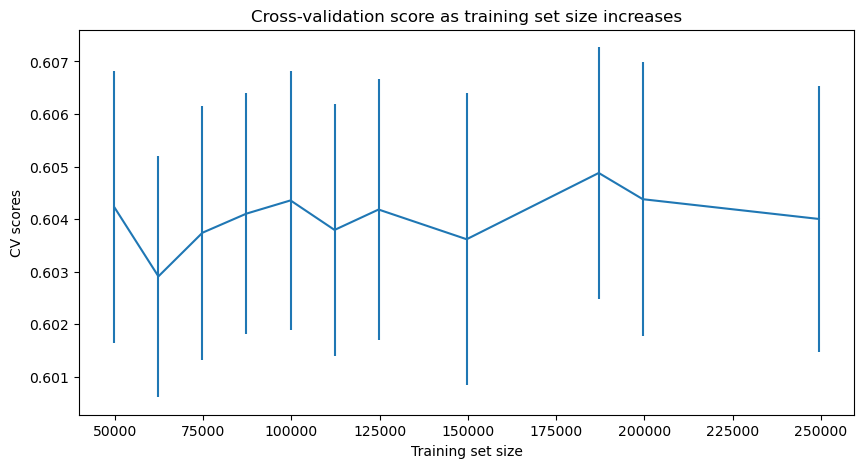

In [254]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

The model benefits from increasing the training data size, as the CV scores stabilize with reduced variability.
However, around 150,000 samples, adding more data doesn't significantly improve performance, suggesting the model might be reaching its capacity.

## Save best model from pipeline

In [259]:
from sklearn import __version__ as sklearn_version
best_model = random_search.best_estimator_
best_model.version = '1.0.4'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [272]:
import os

# Define the function to save the file
def save_file(dataframe, filename, directory):
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    # Construct the full file path
    filepath = os.path.join(directory, filename)
    # Save the DataFrame to the CSV file
    dataframe.to_csv(filepath, index=False)
    print(f"File saved at {filepath}")

# Example usage
datapath = '../data'
save_file(encoded, 'airfare_pricing_model.pkl', datapath)

#modelpath = '../data'
#save_file(best_model, 'airfare_pricing_model.pkl', modelpath)

File saved at ../data/airfare_pricing_model.pkl


## Conclusion

We started with a baseline for median price which was about 13000 rupies for airfare in India. When the dummy regressor was used with the trained variables it also had a median of 13000 rupies, as well as the prediction. Then using the train_test_split linear regression model and training the data with a train sample size of 70% and a test sample size of 30%, we found that the mean absolute error 9500 rupies. This means that if the price were to be estimated it would be about 9500 rupies above or below average, which is not the best prediction, we could do better. The simple linear regression model explains about 56% of the variance on the train set and over 56% on the test set. The cross validation model using selectkbest stated that the best number of k was 68 and the feature that was of most importance to the influence on ticket price was Class_premium (which makes sense since any premium class seat will be more expensive) followed by non stop flights (which decreases the price of flights). The gradient boosting regressor was also tried using a similar pipeline to previous models to assess the performance of random search cross-validation, to reduce computation time. The estimated performance via cross-validation conveyed that the features of most importance were Class_Premium and total_stops_non-stop, which is inconsistent with the previous model. Between the linear regression model performance and the gradient boosting regression model performance there was about a 2000 rupies difference in the cross validation mean absolute error with the gradient boosting being lower (outperforming the simple linear regression model), this is why we will be moving forward with the gradient boosting regression model.